# Spatial domain

The Spatial Domain analysis provides unsupervised (STAGATE) and supervised (AUCell-LMI) methods to detect these structures (called spatial domains) based on gene expression profiles and spatial locations.
We used the kidney cancer Visium sample to perform the two analysis methods separately.

Raw data download from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5924030.
The processed data KIRC_5_Visium_adata.h5ad is stored in https://zenodo.org/records/14588408.

## Read .h5ad data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import SOAPy_st as sp
import os

In [2]:
adata = sc.read_h5ad('/csb2/project/SpatialPackage_whq/Tutorial/data/KIRC_5_Visium_adata.h5ad')

adata_stagate = adata.copy()
adata_graphst = adata.copy()
adata_scanit = adata.copy()

Set up the R environment. If R is not available, skip this step and use cluster_method='louvain' for clustering.

In [3]:
os.environ['R_HOME'] = '/home/wangheqi/anaconda3/envs/SpatialOmics/lib/R/'
os.environ['R_USER'] = '/home/wangheqi/anaconda3/envs/SpatialOmics/lib/python3.9/site-packages/rpy2'

## Unsupervised spatial domian identification

The spatial domain of renal cancer was obtained by `sp.tl.domain_from_unsupervised()` and then clustering using the mclust package in the R environment.

You can refer to DOI: https://doi.org/10.1038/s41592-024-02215-8 to choose the right spatial domain method for you.

### use STAGATE

In [4]:
sc.pp.normalize_total(adata_stagate, target_sum=1e4)
sc.pp.log1p(adata_stagate)
sc.pp.highly_variable_genes(adata_stagate, flavor="seurat_v3", n_top_genes=2000)

In [5]:
adata_stagate = sp.tl.domain_from_unsupervised(
    adata_stagate,
    domain_method='stagate',
    cluster_method='m_clust',
    rad_cutoff=300,
    n_epochs=500,
    cluster_number=8
)# If you don't have the useable R environment, please use cluster_method='louvain'.

------Calculating spatial graph...
The graph contains 10688 edges, 1949 cells.
5.4838 neighbors per cell on average.
Size of Input:  (1949, 2000)


100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.70it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


### use GraphST

In [6]:
adata_graphst = sp.tl.domain_from_unsupervised(
    adata_graphst,
    domain_method='graphst',
    cluster_method='m_clust',
    cluster_number=8
)# If you don't have the useable R environment, please use cluster_method='louvain'.

2025-01-02 17:38:18.823735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-02 17:38:19.963115: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 17:38:20.301835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wangheqi/anaconda3/envs/SpatialOmics/lib/python3.9/site-packages/cv2/../../li

Begin to train ST data...


100%|██████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.52it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%


### use Scan-it

In [7]:
sc.pp.normalize_total(adata_scanit, inplace=True)
sc.pp.log1p(adata_scanit)
sc.pp.scale(adata_scanit)

In [8]:
adata3 = sp.tl.domain_from_unsupervised(
    adata_scanit,
    domain_method='scanit',
    graph_model = 'knn',
    k_cutoff = 6,
    cluster_method='m_clust',
    cluster_number=8,
)# If you don't have the useable R environment, please use cluster_method='louvain'.

Epoch: 000, Loss: 1.4344
Epoch: 500, Loss: 0.0005
Epoch: 999, Loss: 0.0004
fitting ...
  |======================================================================| 100%


In [9]:
# Visualization of spatial domain

In [10]:
adata.obs['STAGATE'] = adata_stagate.obs['domain'].astype(str).tolist()
adata.obs['GraphST'] = adata_graphst.obs['domain'].astype(str).tolist()
adata.obs['SCAN-IT'] = adata_scanit.obs['domain'].astype(str).tolist()

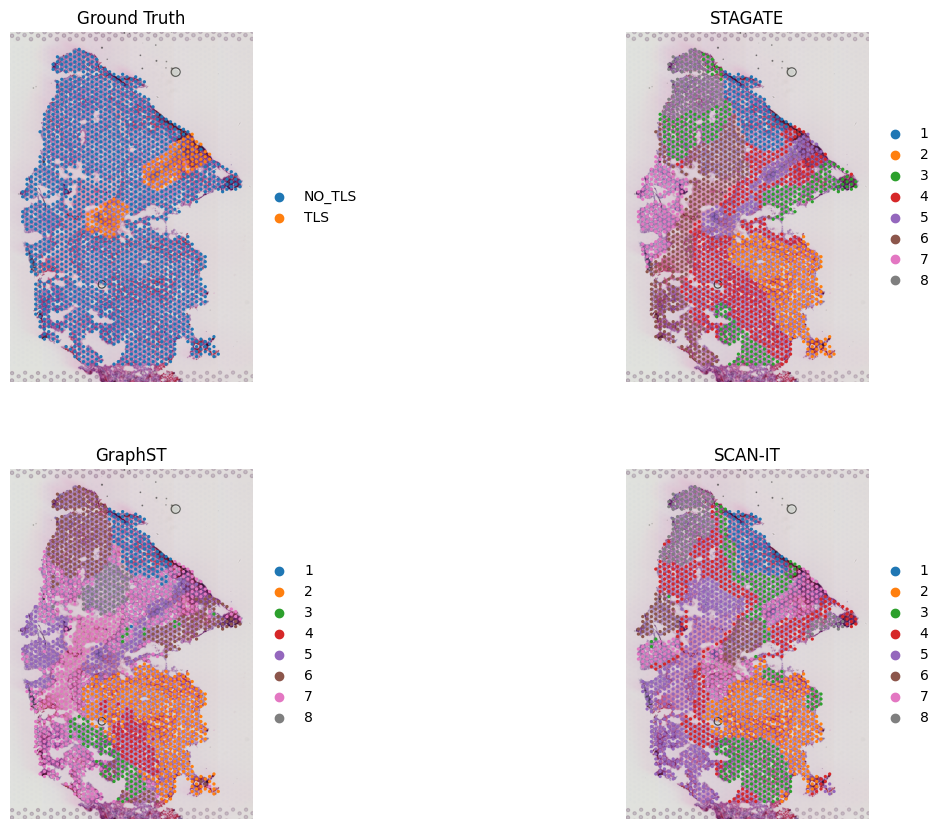

In [11]:
sc.pl.spatial(adata, color=['Ground Truth', 'STAGATE', 'GraphST', 'SCAN-IT'], ncols=2, frameon=False)

## Supervised spatial domian identification

The AUCell score was calculated for each spot based on the gene set of the tertiary lymph node.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

In [13]:
signatures = {'TLS': ['IGHA1', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHGP', 'IGHM', 'IGKC', 'IGLC1',
                      'IGLC2', 'IGLC3', 'JCHAIN', 'CD52', 'CD79A', 'FCRL5', 'MZB1', 'SSR4', 'XBP1', 
                      'TRBC2', 'IL7R', 'CXCL12', 'LUM', 'C1QA', 'C7', 'APOE', 'PTLP', 'PTGDS', 'PIM2', 'DERL3']}

sp.tl.cal_aucell(adata, signatures=signatures)

AnnData object with n_obs × n_vars = 1949 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'STAGATE', 'GraphST', 'SCAN-IT'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'Ground Truth_colors', 'STAGATE_colors', 'GraphST_colors', 'SCAN-IT_colors', 'log1p', 'hvg', 'SOAPy'
    obsm: 'spatial'

The local Moran index of AUCell score was calculated by `sp.tl.domain_from_local_moran`, and the spot with a p-value less than 0.05 was selected as a hotspot.

In [14]:
sp.tl.domain_from_local_moran(
    adata,
    score_key='TLS', 
    spatial_lag_filter=0,
    attribute_filter=0,
    moran_label_key='TLS'
)

attribute_filter: 0
spatial_lag_filter: 0


AnnData object with n_obs × n_vars = 1949 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'STAGATE', 'GraphST', 'SCAN-IT', 'Moran_domain', 'TLS'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'Ground Truth_colors', 'STAGATE_colors', 'GraphST_colors', 'SCAN-IT_colors', 'log1p', 'hvg', 'SOAPy'
    obsm: 'spatial'

The Moran scatter plot shows the distribution of hotspots, with the dotted blue lines representing the attribute_filter and spatial_lag_filter values.

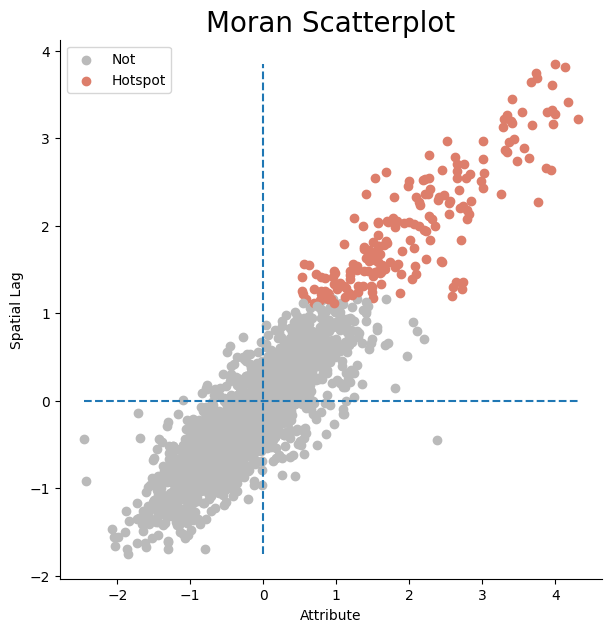

In [15]:
sp.pl.show_moran_scatterplot(adata)

The regions found by local Moran were compared with the manually labeled ground truth.

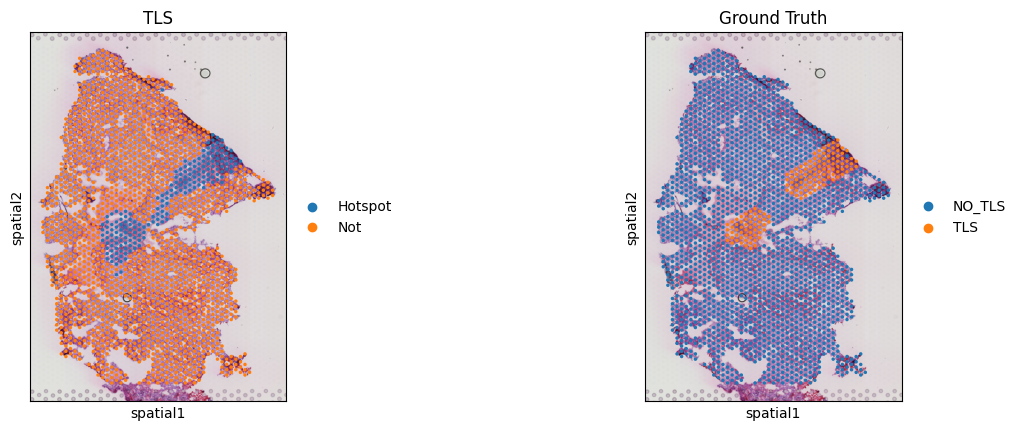

In [16]:
sc.pl.spatial(adata, img_key="hires", color=['TLS', 'Ground Truth'])